In [1]:
import IPython, numpy as np, scipy as sp, matplotlib.pyplot as plt, matplotlib, sklearn, librosa
from IPython.display import Audio
%matplotlib inline

import audio_utils
import vamp

import os

os.environ["VAMP_PATH"] = "./melodia_plugins/"

In [2]:
audio_file = 'wav/hbd_snip.wav'
def melodic_frequency_filepath(filepath):
    audio, sr = librosa.load(filepath, mono=True)
    data = vamp.collect(audio, sr, "mtg-melodia:melodia")
    hop, melody = data['vector']
    return melody

def melodic_frequency(audio, sr):
    data = vamp.collect(audio, sr, "mtg-melodia:melodia")
    hop, melody = data['vector']
    return melody


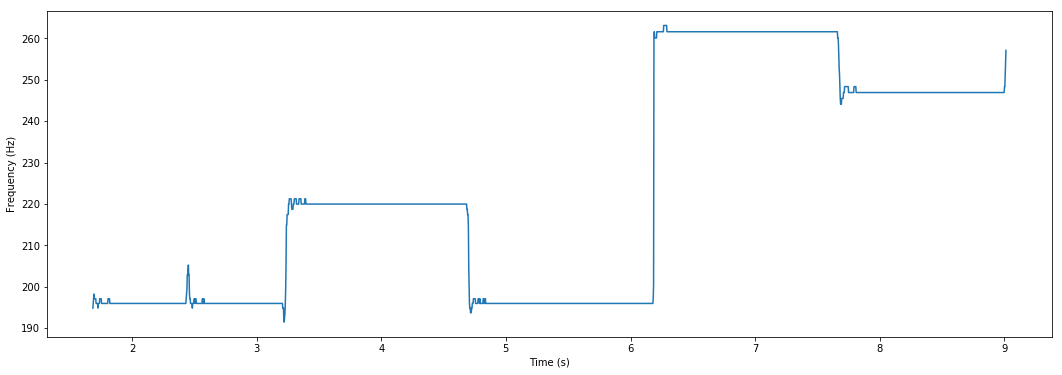

In [3]:
# A clearer option is to get rid of the negative values before plotting
melody = melodic_frequency_filepath('audio/hbd_snip.wav')
# for some reason the internal vamp architecture requires this
timestamps = 8 * 128/44100.0 + np.arange(len(melody)) * (128/44100.0)
melody_pos = melody[:]
melody_pos[melody<=0] = None
plt.figure(figsize=(18,6))
plt.plot(timestamps, melody_pos)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

In [4]:
# Audio(melody, rate=sr)
print(timestamps)

[0.02321995 0.02612245 0.02902494 ... 9.01514739 9.01804989 9.02095238]


In [5]:
vamp_constant = (128/44100.0)

def timestamp_to_index(timestamp):
    index = (timestamp - (8 * vamp_constant)) / vamp_constant
    return int(index)

def find_pitch(start_time, end_time, melody):
    start_index = timestamp_to_index(start_time)
    end_index = timestamp_to_index(end_time)
    relevant_frequencies = melody[start_index:end_index]
    pitch = np.median(relevant_frequencies)
    
    return pitch



In [6]:
happy = find_pitch(2,3,melody)
birth = find_pitch(3.5, 4.5, melody)
day = find_pitch(5,6,melody)
to = find_pitch(6.5, 7.5, melody)
you = find_pitch(8,9, melody)
print(happy)
print(birth)
print(day)
print(to)
print(you)

195.99771
220.0
195.99771
261.62558
246.94165


In [ ]:
from pydub import AudioSegment
from pydub.silence import split_on_silence
from pydub.utils import get_array_type

sound_file = AudioSegment.from_wav("audio/speech.wav")
sr = 44100

audio_chunks = split_on_silence(sound_file, min_silence_len=25, silence_thresh=-15)

all_segments = [np.array(chunk.get_array_of_samples(),dtype=float) for chunk in audio_chunks]
print('all_segments', all_segments)

voice_chunk_melody = [melodic_frequency(chunk, sr) for chunk in all_segments]

voice_chunk_freq = [np.median(melody) for melody in voice_chunk_melody]



In [ ]:
hbd_snip, sr = librosa.load("audio/hbd_snip.wav")
# sr = 44100
onset_frames = librosa.onset.onset_detect(hbd_snip, sr=sr)
onset_times = librosa.frames_to_time(onset_frames)

def onset_interval(i, onset_start, onset_times, last_timestamp):
    if i+1 >= len(onset_times):
        return (onset_start, last_timestamp)
    else:
        return (onset_start, onset_times[i+1])        

onset_intervals = [ onset_interval(i, onset, onset_times, len(hbd_snip)/ sr) for i, onset in enumerate(onset_times) ]

hbd_melody = melodic_frequency(hbd_snip, sr)
hbd_freqs = [find_pitch(start, end, hbd_melody) for start, end in onset_intervals]

print('onset times', onset_times)
print('onset intervals', onset_intervals)
print('voice freq', voice_chunk_freq)
print('hbd freq', hbd_freqs)


In [ ]:
# fn = [196, 196, 220, 196, 260]
# f0 = [186.6, 190.4, 162.9, 167.7]

def autotune(signal_chunks, fn, f0, sr):
    shifted_signal = []
    length = min( len(fn), len(f0) )
    for i in range(length):

        n_steps = np.round(np.log2(float(fn[i])/f0[i]) * 12)
        print(n_steps)

        shifted_segment = librosa.effects.pitch_shift(signal_chunks[i], sr, n_steps)
        shifted_signal.append(shifted_segment)
        
    return shifted_signal

autotune(all_segments, hbd_freqs, voice_chunk_freq, sr)

print("Generated Happy Birthday Text")
IPython.display.display(Audio(hbd_raw, rate=sr))

shifted_signal = np.concatenate(shifted_signal)
audio_utils.plot_audio(shifted_signal, sr=sr)
IPython.display.display(Audio(shifted_signal, rate=sr))